In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score,roc_curve,
                            ConfusionMatrixDisplay, auc,
                            precision_score, recall_score, f1_score)

In [2]:
# 1. Set the folder path
# --------------------------------------------------
train_REAL = "data/train/REAL"
train_FAKE = "data/train/FAKE"
test_REAL = "data/test/REAL"
test_FAKE = "data/test/FAKE"

In [3]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [4]:
# Normalize pixels to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Flatten images
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

print(f"Train shape: {X_train_flat.shape}")  # (100000, 3072)
print(f"Test shape: {X_test_flat.shape}")    # (20000, 3072)

Train shape: (100000, 3072)
Test shape: (20000, 3072)


In [5]:
USE_FULL_DATASET = False  # Set to False to use subset

if USE_FULL_DATASET:
    X_train_final = X_train_flat
    y_train_final = y_train
    X_test_final = X_test_flat
    y_test_final = y_test
else:
    X_train_final, _, y_train_final, _ = train_test_split(
        X_train_flat, y_train,
        train_size=20000,
        stratify=y_train,
        random_state=42
    )
    X_test_final, _, y_test_final, _ = train_test_split(
        X_test_flat, y_test,
        train_size=5000,
        stratify=y_test,
        random_state=42
    )
    print(f"\nUsing reduced dataset:")
    print(f"Train shape: {X_train_final.shape}")
    print(f"Test shape: {X_test_final.shape}")


Using reduced dataset:
Train shape: (20000, 3072)
Test shape: (5000, 3072)


In [6]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_final, y_train_final,
    test_size=0.2,
    stratify=y_train_final,
    random_state=42
)
print(f"Training set: {X_train_sub.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (16000, 3072)
Validation set: (4000, 3072)


In [7]:
xgb_model = xgb.XGBClassifier(
    # Tree parameters
    n_estimators=200,           # Number of trees
    max_depth=8,                # Maximum tree depth
    learning_rate=0.05,         # Step size shrinkage
    
    # Sampling parameters
    subsample=0.8,              # Row sampling per tree
    colsample_bytree=0.8,       # Feature sampling per tree
    colsample_bylevel=0.8,      # Feature sampling per level
    
    # Regularization
    min_child_weight=3,         # Minimum sum of instance weight in child
    gamma=0.1,                  # Minimum loss reduction for split
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    
    # Other parameters
    objective='binary:logistic', # Binary classification
    eval_metric='logloss',      # Evaluation metric
    random_state=42,
    tree_method='hist',         # Fast histogram-based method
    n_jobs=-1,                  # Use all CPU cores
    early_stopping_rounds=10    # Stop if no improvement for 10 rounds
)

In [8]:
%%time
# Train with validation monitoring
xgb_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=20  # Print every 20 iterations
)

[0]	validation_0-logloss:0.67634	validation_1-logloss:0.68101
[20]	validation_0-logloss:0.47568	validation_1-logloss:0.54476
[40]	validation_0-logloss:0.38638	validation_1-logloss:0.48852
[60]	validation_0-logloss:0.33824	validation_1-logloss:0.45922
[80]	validation_0-logloss:0.30479	validation_1-logloss:0.44009
[100]	validation_0-logloss:0.27503	validation_1-logloss:0.42375
[120]	validation_0-logloss:0.25349	validation_1-logloss:0.41160
[140]	validation_0-logloss:0.23517	validation_1-logloss:0.40207
[160]	validation_0-logloss:0.21634	validation_1-logloss:0.39286
[180]	validation_0-logloss:0.19522	validation_1-logloss:0.38416
[199]	validation_0-logloss:0.17950	validation_1-logloss:0.37807
CPU times: user 7min 3s, sys: 33.3 s, total: 7min 36s
Wall time: 1min 9s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [9]:

y_train_pred = xgb_model.predict(X_train_final)
y_test_pred = xgb_model.predict(X_test_final)

# Get prediction probabilities
y_test_proba = xgb_model.predict_proba(X_test_final)[:, 1]

In [10]:
class_names = ['Fake', 'Real'] 

In [11]:
print(classification_report(y_train_final, y_train_pred, 
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.9563    0.9367    0.9464     10000
        Real     0.9380    0.9572    0.9475     10000

    accuracy                         0.9469     20000
   macro avg     0.9471    0.9469    0.9469     20000
weighted avg     0.9471    0.9469    0.9469     20000



In [12]:
print(classification_report(y_test_final, y_test_pred, 
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.8295    0.8328    0.8311      2500
        Real     0.8321    0.8288    0.8305      2500

    accuracy                         0.8308      5000
   macro avg     0.8308    0.8308    0.8308      5000
weighted avg     0.8308    0.8308    0.8308      5000



In [43]:
xgb_model2 = xgb.XGBClassifier(
    # Tree parameters
    n_estimators=200,           # Number of trees
    max_depth=10,                # Maximum tree depth
    learning_rate=0.05,         # Step size shrinkage
    
    # Sampling parameters
    subsample=0.8,              # Row sampling per tree
    colsample_bytree=0.8,       # Feature sampling per tree
    colsample_bylevel=0.8,      # Feature sampling per level
    
    # Regularization
    min_child_weight=3,         # Minimum sum of instance weight in child
    gamma=0.1,                  # Minimum loss reduction for split
    reg_alpha=0,              # L1 regularization
    reg_lambda=5,             # L2 regularization
    
    # Other parameters
    objective='binary:logistic', # Binary classification
    eval_metric='logloss',      # Evaluation metric
    random_state=42,
    tree_method='hist',         # Fast histogram-based method
    n_jobs=-1,                  # Use all CPU cores
    early_stopping_rounds=10    # Stop if no improvement for 10 rounds
)

In [44]:
%%time
# Train with validation monitoring
xgb_model2.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=20  # Print every 20 iterations
)

[0]	validation_0-logloss:0.67484	validation_1-logloss:0.68071
[20]	validation_0-logloss:0.45423	validation_1-logloss:0.54092
[40]	validation_0-logloss:0.36087	validation_1-logloss:0.48444
[60]	validation_0-logloss:0.31170	validation_1-logloss:0.45316
[80]	validation_0-logloss:0.27557	validation_1-logloss:0.43250
[100]	validation_0-logloss:0.24720	validation_1-logloss:0.41680
[120]	validation_0-logloss:0.21932	validation_1-logloss:0.40350
[140]	validation_0-logloss:0.19860	validation_1-logloss:0.39386
[160]	validation_0-logloss:0.17906	validation_1-logloss:0.38482
[180]	validation_0-logloss:0.16084	validation_1-logloss:0.37708
[199]	validation_0-logloss:0.14480	validation_1-logloss:0.37070
CPU times: user 10min 5s, sys: 48.5 s, total: 10min 54s
Wall time: 1min 37s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [45]:

y_train_pred2 = xgb_model2.predict(X_train_final)
y_test_pred2 = xgb_model2.predict(X_test_final)

In [46]:
print(classification_report(y_train_final, y_train_pred2, 
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.9613    0.9519    0.9566     10000
        Real     0.9524    0.9617    0.9570     10000

    accuracy                         0.9568     20000
   macro avg     0.9568    0.9568    0.9568     20000
weighted avg     0.9568    0.9568    0.9568     20000



In [47]:
print(classification_report(y_test_final, y_test_pred2, 
                          target_names=class_names,
                          digits=4))

              precision    recall  f1-score   support

        Fake     0.8400    0.8440    0.8420      2500
        Real     0.8432    0.8392    0.8412      2500

    accuracy                         0.8416      5000
   macro avg     0.8416    0.8416    0.8416      5000
weighted avg     0.8416    0.8416    0.8416      5000



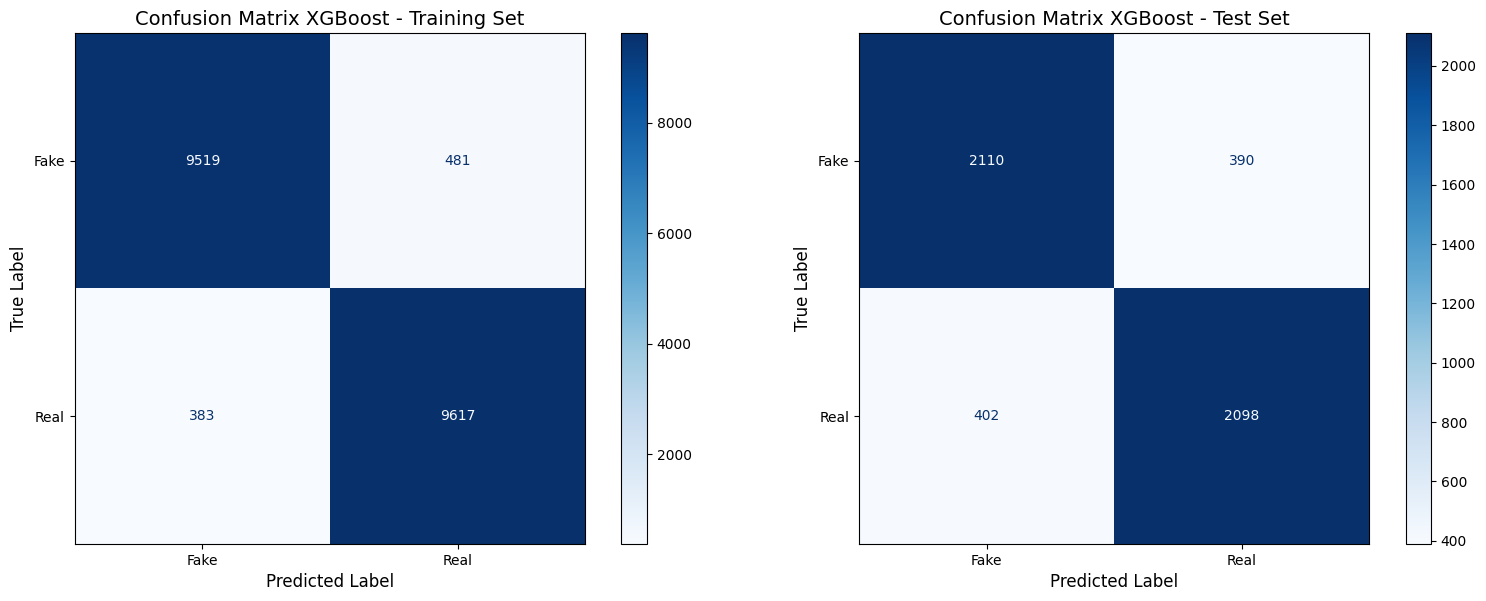

In [48]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train_final, y_train_pred2)
cm_test = confusion_matrix(y_test_final, y_test_pred2)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                     display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix XGBoost - Training Set', fontsize=14)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].grid(False)

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                    display_labels=class_names)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix XGBoost - Test Set', fontsize=14)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].grid(False)

plt.tight_layout()
plt.show()

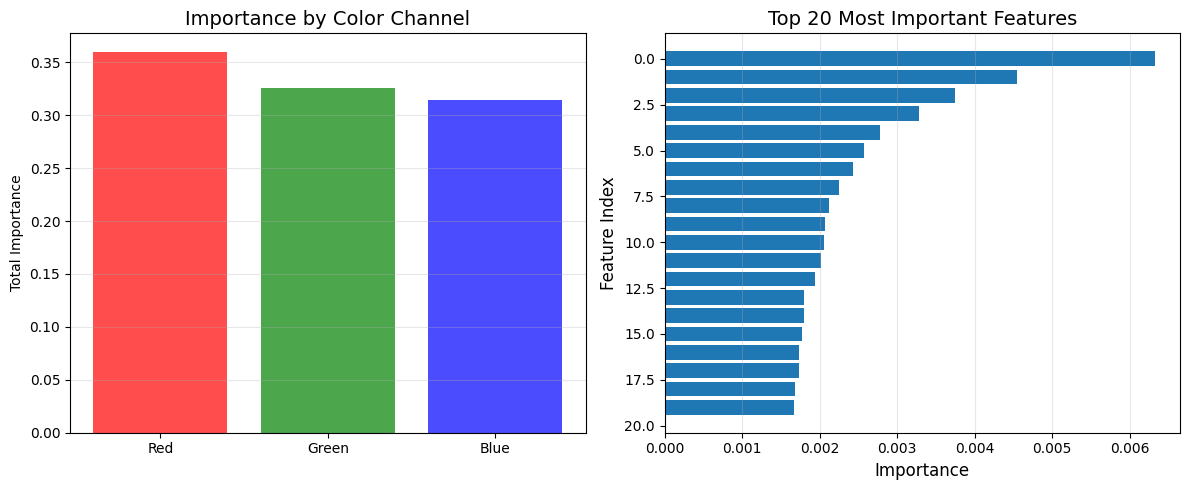

In [56]:
# Get feature importance
importance = xgb_model.feature_importances_

# Reshape back to image dimensions for visualization
importance_img = importance.reshape(32, 32, 3)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Per channel
channel_importance = [importance_img[:, :, i].sum() for i in range(3)]
axes[0].bar(['Red', 'Green', 'Blue'], channel_importance, color=['red', 'green', 'blue'], alpha=0.7)
axes[0].set_title("Importance by Color Channel", fontsize=14)
axes[0].set_ylabel("Total Importance")
axes[0].grid(axis='y', alpha=0.3)

# Top features
top_n = 20
top_indices = np.argsort(importance)[-top_n:][::-1]
axes[1].barh(range(top_n), importance[top_indices])
axes[1].set_xlabel("Importance", fontsize=12)
axes[1].set_ylabel("Feature Index", fontsize=12)
axes[1].set_title(f"Top {top_n} Most Important Features", fontsize=14)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

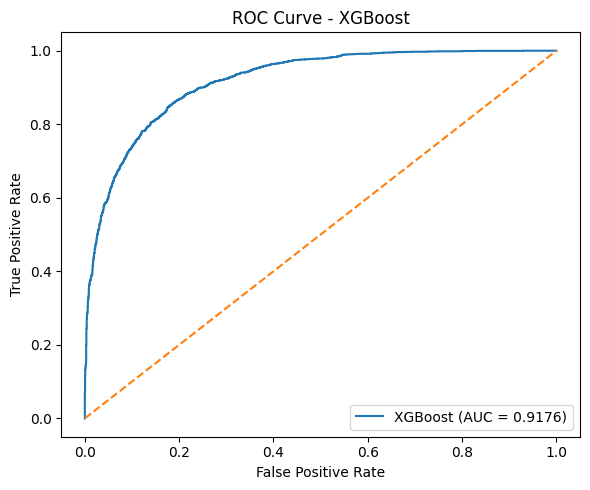

In [54]:
y_prob_xgb = xgb_model.predict_proba(X_test_final)[:, 1]

# Calculate ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_final, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

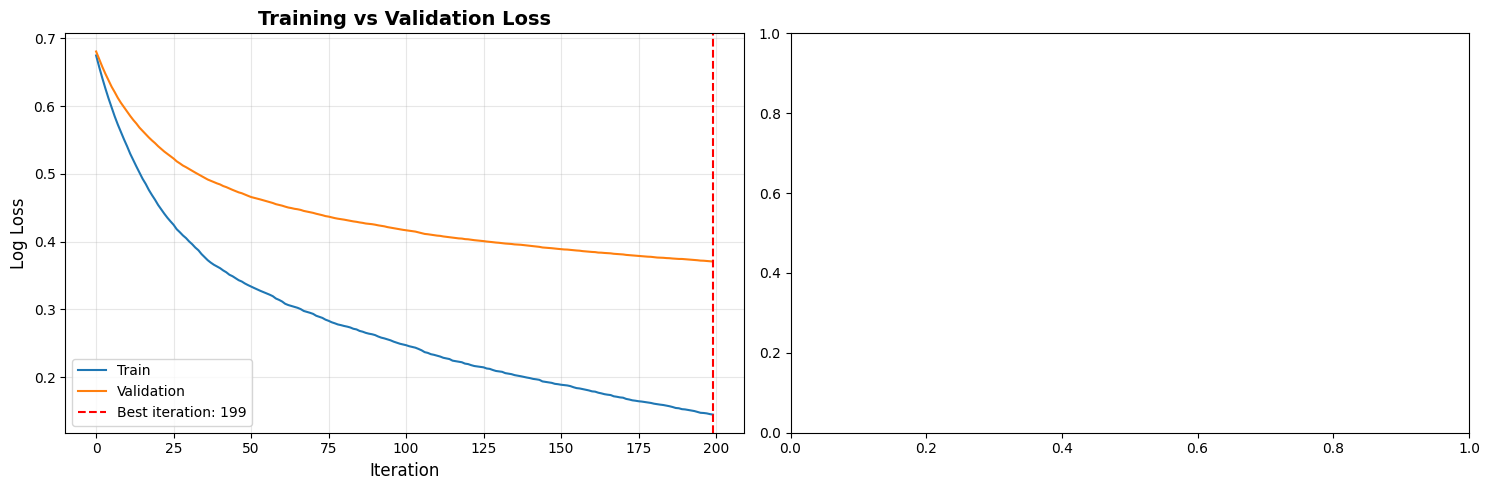

In [55]:
results = xgb_model2.evals_result()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(results['validation_0']['logloss'], label='Train')
axes[0].plot(results['validation_1']['logloss'], label='Validation')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Log Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Best iteration marker
best_iteration = xgb_model.best_iteration
axes[0].axvline(x=best_iteration, color='r', linestyle='--', 
                label=f'Best iteration: {best_iteration}')
axes[0].legend()

# # Accuracy over iterations (calculate from predictions)
# train_sizes = range(10, len(X_train_sub) + 1, len(X_train_sub) // 10)
# train_scores = []
# val_scores = []

# for size in train_sizes:
#     temp_model = xgb.XGBClassifier(n_estimators=100, max_depth=8, 
#                                     learning_rate=0.05, random_state=42,
#                                     tree_method='hist', n_jobs=-1)
#     temp_model.fit(X_train_sub[:size], y_train_sub[:size])
#     train_scores.append(temp_model.score(X_train_sub[:size], y_train_sub[:size]))

# axes[1].plot(train_sizes, train_scores, 'o-', label='Train', alpha=0.8)
# axes[1].plot(train_sizes, val_scores, 'o-', label='Validation', alpha=0.8)
# axes[1].set_xlabel('Training Set Size', fontsize=12)
# axes[1].set_ylabel('Accuracy', fontsize=12)
# axes[1].set_title('Learning Curve', fontsize=14, fontweight='bold')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
AU